In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import networkx as nx

SEED = 123
SAMPLES_SIZE = 1000

MODEL_PATH_1 = "temp_code1.stan"
MODEL_PATH_1_PPC = "temp_code1_ppc.stan"

GTD_DATA_PATH = "data/globalterrorismdb_0718dist.csv"

In [2]:
def plot_scatter_with_hist(val_mat, y_values):
    fig, axs = plt.subplots(2, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5*len(val_mat.columns), 10)

    for i, col in enumerate(val_mat.columns):
        axs[0, i].scatter(val_mat[col], y_values)
        axs[0, i].set_title(col)
        axs[0, i].set_ylabel(y_values.name)
        axs[0, i].grid()

        axs[1, i].hist(val_mat[col])
        axs[1, i].set_ylabel("Density")
        axs[1, i].set_xlabel(col)
        axs[1, i].grid()

def plot_prior_histograms_compare(data_real, stan_variable_data):
    data_gen = stan_variable_data.flatten()
    data_gen, unique = np.unique(data_gen, return_counts=True)
    data_gen = data_gen / 4000
    
    k = int(np.ceil(2 * np.power(SAMPLES_SIZE, 1/3)))
    bins = range(0, k)
    real_max = int(data_real.max())
    i = 0
    
    while (data_gen[i] < real_max):
        i += 1
        if (i >= len(data_gen)):
            break        
    data_gen = data_gen[:i]
    
    plt.figure(dpi=150)
    sns.histplot(data_real, bins=bins, alpha=0.5, kde=True, label="Real")
    sns.histplot(data_gen, bins=bins, alpha=0.5, kde=True, label="Generated")
    plt.title("Generated samples")
    plt.xlabel(data_real.name)
    plt.ylabel("count")
    plt.xlim([0, min(18, k)])
    plt.legend()
    plt.show()

1000 rows in the dataset after filtering


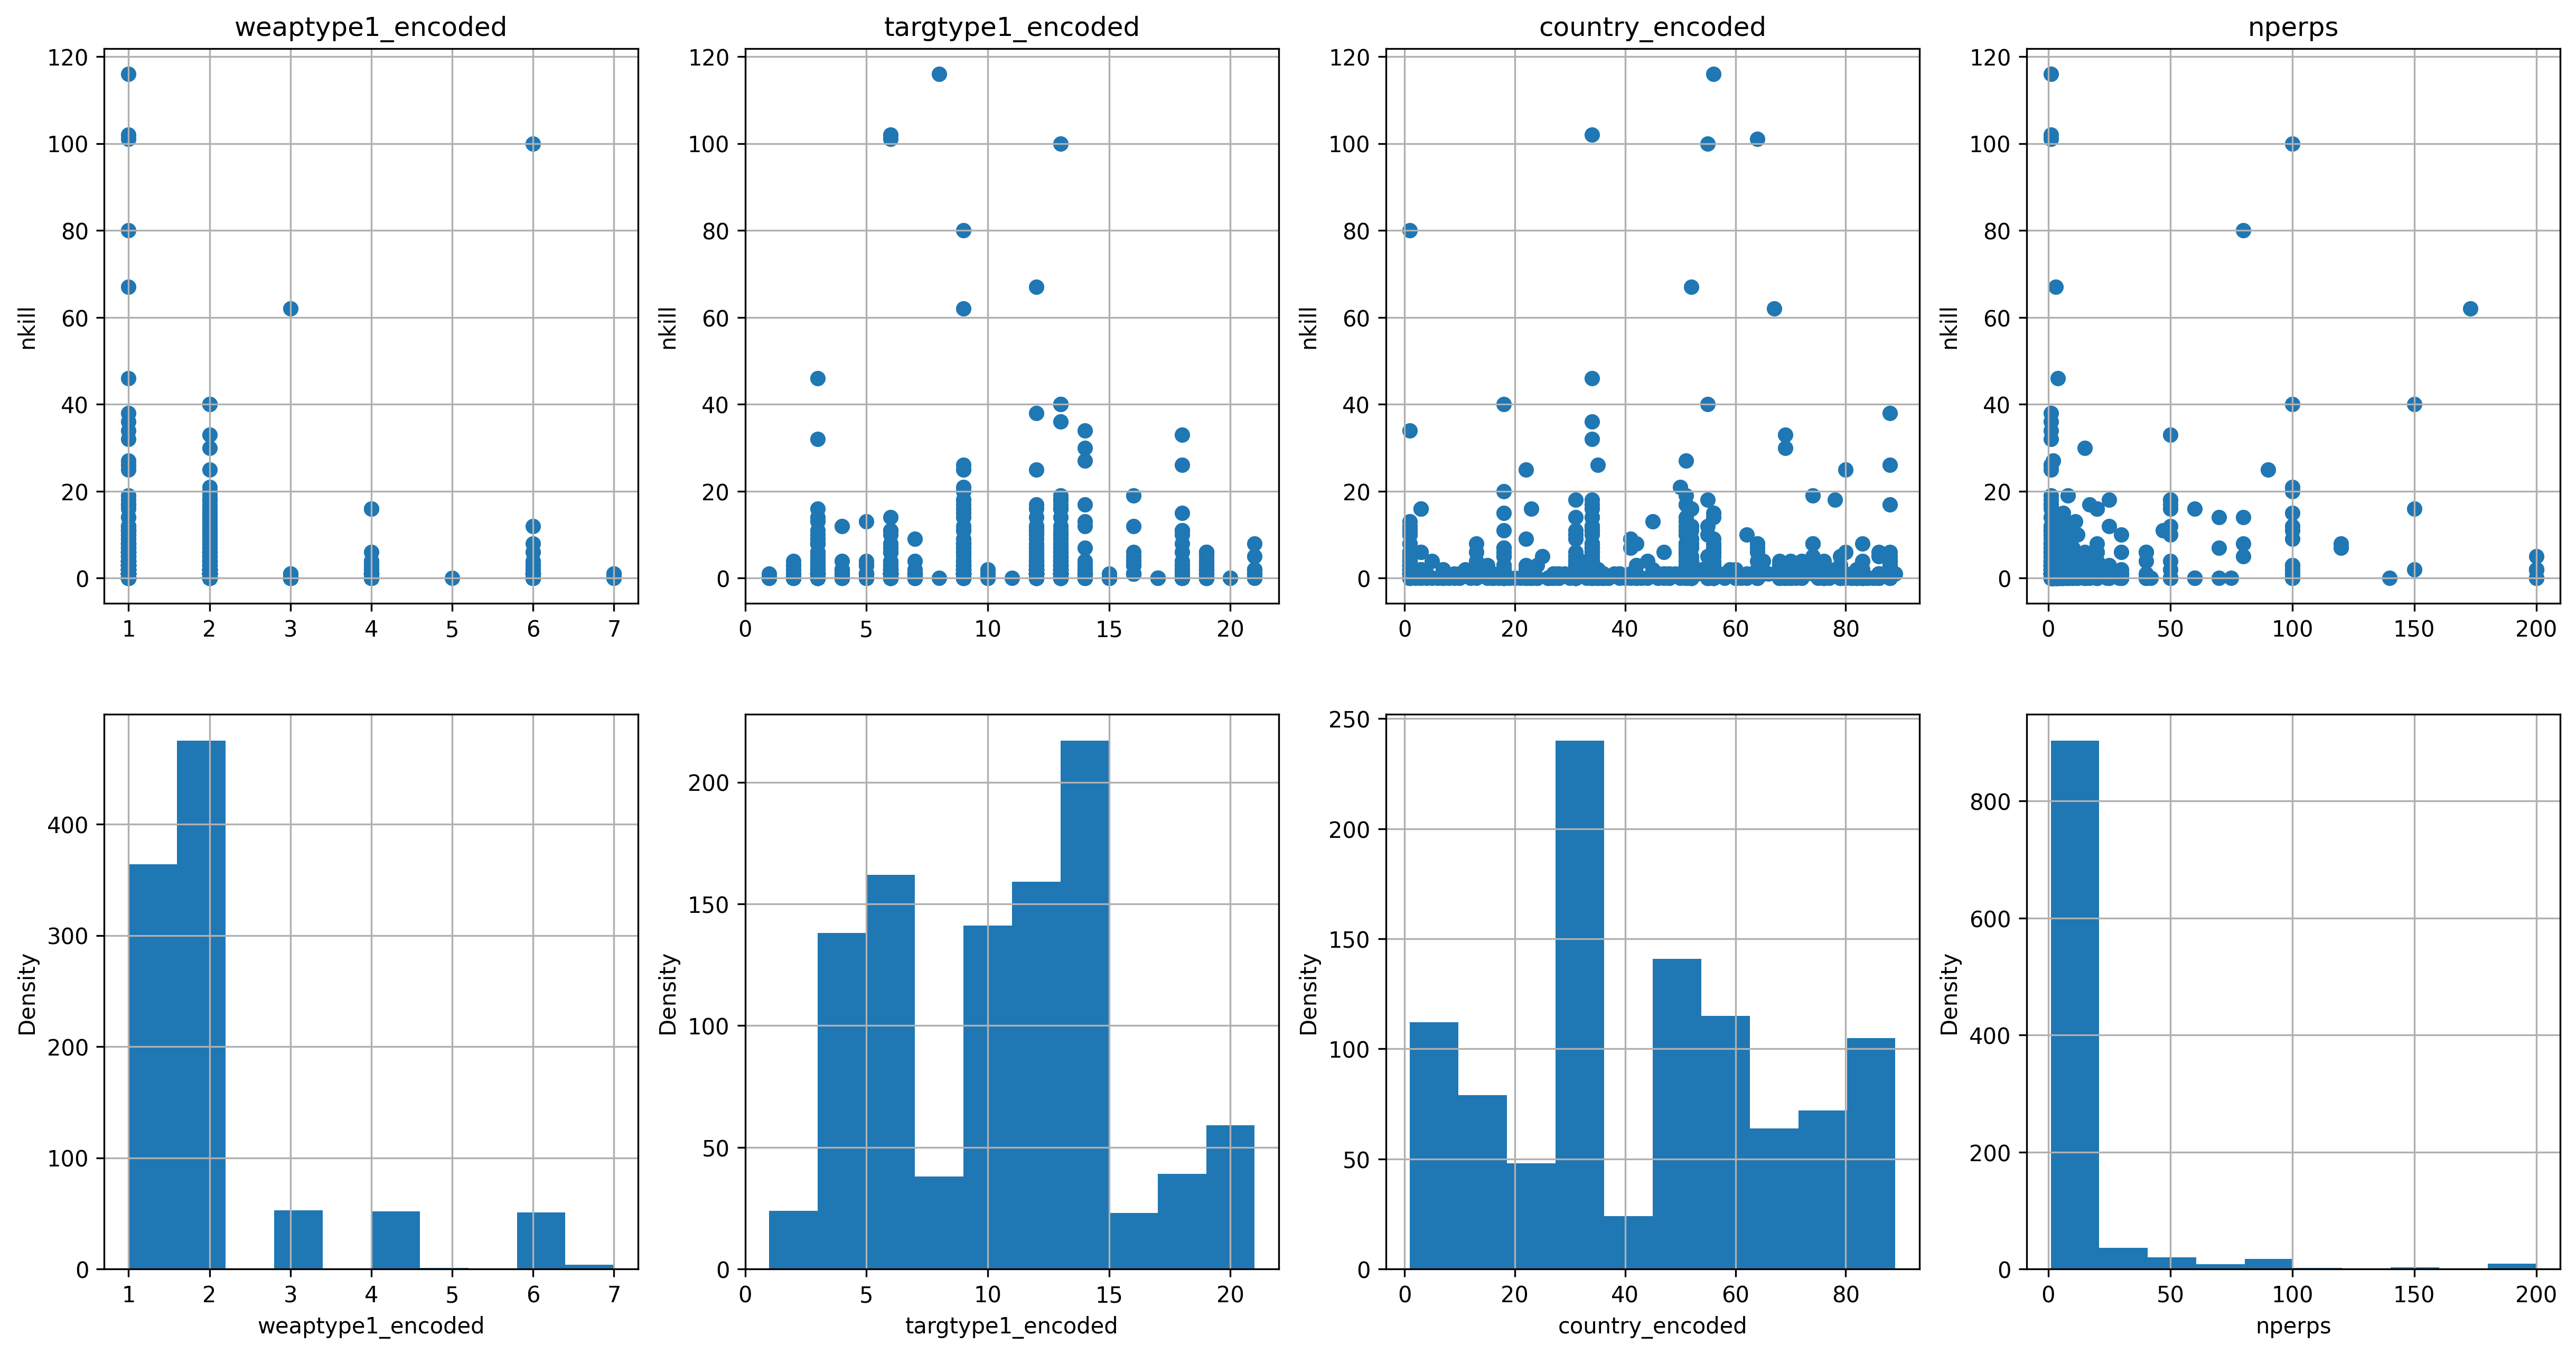

In [3]:
df = pd.read_csv(GTD_DATA_PATH, encoding='latin-1', low_memory=False)
categorical_columns = ['weaptype1_txt', 'targtype1_txt', 'country_txt']
predictors = categorical_columns + ['nperps']
selected_columns = ['nkill'] + predictors
df = df[selected_columns].dropna()
df = df[df['nperps'] > 0 ]
df = df[df['nperps'] < 250 ]
df = df[df['nkill'] < 500 ]


df = df.sample(n=SAMPLES_SIZE, random_state=SEED)
print(len(df), "rows in the dataset after filtering")

for column in categorical_columns:
    le = LabelEncoder()
    df[column.replace("txt", "encoded")] = le.fit_transform(df[column]) + 1

selected_columns = ["weaptype1_encoded", "targtype1_encoded", "country_encoded", "nperps"]
df_data = df[selected_columns]

weaptype1 = df['weaptype1_encoded'].values
targtype1 = df['targtype1_encoded'].values
country = df['country_encoded'].values
X_cont = df['nperps']
X_cont = ((X_cont - X_cont.mean()) / X_cont.std()).values
nkill = df['nkill'].values

df2 = df[['nkill', 'weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']]

stan_data_pcc = {
        'N': len(df),
        'K_cont': 1,
        'K_weaptype': int(weaptype1.max()),
        'K_targtype': int(targtype1.max()),
        'K_country': int(country.max()),
        'X_cont': X_cont.reshape(-1, 1),
        'weaptype': weaptype1.tolist(),
        'targtype': targtype1.tolist(),
        'country': country.tolist()
}

stan_data = {
        'N': len(df),
        'K_cont': 1,                         # 1 since we got only 1 column
        'K_weaptype': int(weaptype1.max()),  # number of weapon types
        'K_targtype': int(targtype1.max()),  # number of target types
        'K_country': int(country.max()),     # number of countries
        'X_cont': X_cont.reshape(-1, 1),
        'weaptype': weaptype1.tolist(),
        'targtype': targtype1.tolist(),
        'country': country.tolist(),
        'nkill': np.array(nkill, dtype=int).tolist()
}

plot_scatter_with_hist(df2[['weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']], df2["nkill"])

In [18]:
model1_ppc = CmdStanModel(stan_file=MODEL_PATH_1_PPC)
sim1_ppc = model1_ppc.sample(
    data=stan_data_pcc,
    seed=SEED,
    chains=1,
    iter_sampling=1000,
    iter_warmup=1000,
)

df_1_ppc = sim1_ppc.draws_pd()

07:04:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

07:04:25 - cmdstanpy - INFO - CmdStan done processing.


In [27]:
data_real = df2["nkill"]
data_gen = sim1_ppc.stan_variable("nkill_prior_pred")




In [ ]:
# data_real = df2["nkill"]
# data_gen = sim1_ppc.stan_variable("nkill_prior_pred")


# gen_mean = np.mean(data_gen, axis=0)
# print(gen_mean.shape)

# ser = pd.Series(gen_mean)
# display(ser.describe())
# ser.hist(bins=1000)
# plt.xlim([0, 18])
# plt.show()



# data_gen, counts = np.unique(data_gen, return_counts=True, axis=0)
# data_gen = data_gen / 4000

    
# k = int(np.ceil(2 * np.power(SAMPLES_SIZE, 1/3)))
# bins = range(0, k)
# real_max = int(data_real.max())
# i = 0
    
# while (data_gen[i] < real_max):
#     i += 1
#     if (i >= len(data_gen)):
#         break        
# data_gen = data_gen[:i]
    
# plt.figure(dpi=150)
# sns.histplot(data_real, bins=bins, alpha=0.5, kde=True, label="Real")
# sns.histplot(counts / 4000, bins=bins, alpha=0.5, kde=True, label="Generated")
# plt.title("Generated samples")
# plt.xlabel(data_real.name)
# plt.ylabel("count")
# plt.xlim([0, min(18, k)])
# plt.legend()
# plt.show()